# How many stars will I give? Predicting ratings of Amazon reviews

----------------
## Purpose
Many product reviews (from other platforms than Amazon) are not accompanied by a scale rating system, consisting only of a textual evaluation. In this case, it becomes daunting and time-consuming to compare different products in order to eventually make a choice between them. Therefore, models able to predict the user rating from the text review are critically important. Getting an overall sense of a textual review could in turn improve consumer experience. Also, it can help business to increase sales, and improve the product by understanding customers' needs and pain-points.

The purpose of this project is to develop models that are able to predict the user rating from the text review. While our model is built to work with any kind of product, the review dataset provided by Amazon only includes Clothing and Shoes  reviews.
 
## Data-Source
Amazon product data:  http://jmcauley.ucsd.edu/data/amazon/

## Sample review:
    "reviewerID": "A2SUAM1J3GNN3B",  
    "asin": "0000013714",  
    "reviewerName": "J. McDonald",  
    "helpful": [2, 3],  
    "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  
    "overall": 5.0,  
    "summary": "Heavenly Highway Hymns",  
    "unixReviewTime": 1252800000,  
    "reviewTime": "09 13, 2009"  

----------------
## I. Preparing Amazon dataset

In [1]:
##########################################
## 1.1 IMPORT DATA IN PANDAS
##########################################
import pandas as pd

review_df = pd.read_json('Amazon_reviews/Clothing_Shoes_and_Jewelry_5.json', orient='records', lines=True)

In [2]:
##########################################
## 1.2 CHECK DATA IN PANDAS
##########################################

# change column name 
review_df = review_df.rename(columns={'overall': 'Rating'})

print ("Total data:", str(review_df.shape))
review_df.head(10)

Total data: (278677, 9)


,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600
5,0000031887,"[0, 0]",4,I received this today and I'm not a fan of it ...,"03 31, 2014",A27UF1MSF3DB2,"C-Lo ""Cynthia""",It's ok,1396224000
6,0000031887,"[0, 0]",5,Bought this as a backup to the regular ballet ...,"05 3, 2014",A16GFPNVF4Y816,design maven,Great for dress-up and for ballet practice,1399075200
7,0000031887,"[0, 0]",5,Great tutu for a great price. It isn't a &#34;...,"12 23, 2012",A2M2APVYIB2U6K,Jamie P.,Great value,1356220800
8,0000031887,"[0, 0]",4,"My daughter liked this, and it with her costum...","11 10, 2013",A1NJ71X3YPQNQ9,JBerger,Good,1384041600
9,0000031887,"[7, 8]",5,For what I paid for two tutus is unbeatable an...,"10 7, 2012",A3EERSWHAI6SO,"Jeffrey Hollingshead ""Jillian hollingshead""",WOW !! ..is all I have to say!,1349568000


In [3]:
len(review_df['reviewerID'].unique())

39387

## II. Preliminary Analysis

In [12]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(review_df)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(review_df.reviewerID.unique()))
reviewer_prop = float(len(review_df.reviewerID.unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(review_df.asin.unique()))
product_prop = float(len(review_df.asin.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(review_df.Rating.mean(),3))

print ("================================================")

Number of reviews:  278677

Number of unique reviewers:  39387
Prop of unique reviewers:  0.141

Number of unique products:  23033
Prop of unique products:  0.083

Average rating score:  4.245


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

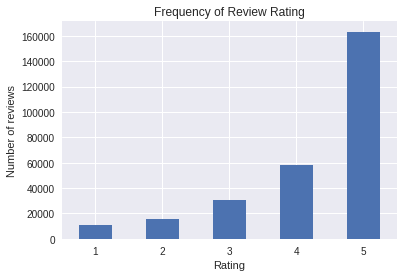

In [10]:
##########################################
## 2.2 DISTRIBUTION OF RATING SCORE
########################################## 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

review_df.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

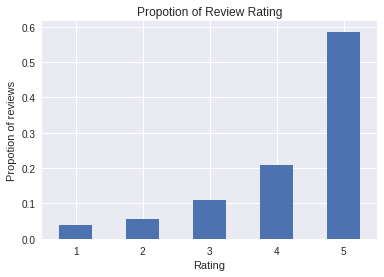

In [16]:
##########################################
## 2.3 DISTRIBUTION OF RATING PROPOTION
########################################## 

(review_df.groupby('Rating').size()/total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

In [59]:
######################
## 2.4 SUBSET DATA
######################

from datetime import datetime
def toDate(dt_str):
    return datetime.strptime(dt_str, '%m %d, %Y')

## select review time before 2012
dt_year = toDate('01 01, 2012')
review_df['reviewDate'] = review_df.reviewTime.apply(toDate)
sdf = review_df[review_df.reviewDate < dt_year]
sub_total = len(sdf)
print (sub_total)

16434


In [24]:
class_counts = sdf.groupby('Rating').size()
class_counts

Rating
1      690
2      861
3     1518
4     3363
5    10002
dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

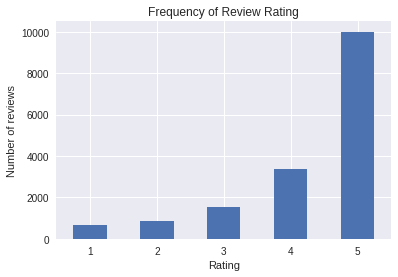

In [25]:
sdf.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

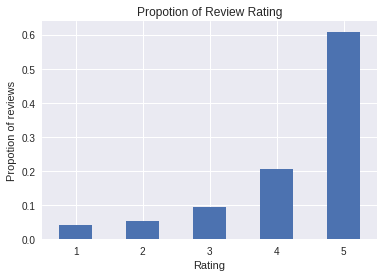

In [28]:
(sdf.groupby('Rating').size()/sub_total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

## III. Pre-processing —— Text Normalization (Text Wrangling)
Text normalization is defined as a process that consists of a series of steps that should be followed to wrangle, clean, and standardize textual data into a form that
could be consumed by other NLP and analytics systems and applications as input. Besides tokenization, various other techniques include cleaning text, case conversion, correcting spellings,
removing stopwords and other unnecessary terms, stemming, and lemmatization. Text normalization is also often called text cleansing or wrangling.  
* __Expanding Contractions__
* __Removing Special Characters__
* __Case Conversions__
* __Tokenizing Text__
* __Removing Stopwords__
* __Correcting Words__
* __Lemmatization__

In [29]:
import nltk
import re
import string
from pprint import pprint

In [60]:
sdf.index = range(sub_total)
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewDate
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800,2011-02-12
1,0000031887,"[0, 0]",5,Purchased this tutu for my granddaughter's fir...,"11 12, 2011",A391EXIT5TFP72,Lisbeth Starr,Wonderful tutu!,1321056000,2011-11-12
2,1608299953,"[201, 205]",4,"The product itself is five stars, however the ...","12 4, 2011",A3INPLAFCMRI3I,Cheryl,4 stars BUT beware...,1322956800,2011-12-04
3,1608299953,"[5, 6]",4,The first question was which computers to inst...,"09 21, 2010",A3NHUQ33CFH3VM,Citizen John,Intense way to learn,1285027200,2010-09-21
4,1608299953,"[11, 13]",5,"Okay, I admit it. I'm one of the millions of A...","06 16, 2011",A253TILLU81VZK,D. Connelly,Helped me actually get an A in a foreign langu...,1308182400,2011-06-16


### 1. Expanding Contractions
Contractions are shortened version of words or syllables. They exist in either written or spoken forms. Shortened versions of existing words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word.  
By nature, contractions do pose a problem for NLP and text analytics because, to start with, we have a special apostrophe character in the word. 

In [58]:
from contractions import CONTRACTION_MAP

# Define function to expand contractions
def expand_contractions(sentence, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                        if contraction_mapping.get(match)\
                        else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence

In [61]:
# Expand contractions of reviewText 
sdf = sdf.assign(expanded_reviewText = [expand_contractions(sentence, CONTRACTION_MAP) for sentence in sdf.reviewText])

In [63]:
# Expand contractions of summary 
sdf = sdf.assign(expanded_summary = [expand_contractions(sentence, CONTRACTION_MAP) for sentence in sdf.summary])

### 2. Removing Special Characters
One important task in text normalization involves removing unnecessary and *special characters*. These may be special symbols or even punctuation that occurs in sentences. This step is often performed before or after tokenization. The main reason for doing so is because often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML.

In [93]:
# Define the function to remove special characters
def remove_characters(sentence):
    sentence = sentence.strip()
    PATTERN = '[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    filtered_sentence = re.sub(PATTERN, '', sentence)
    return filtered_sentence

In [95]:
# Remove special characters & Case Conversions in reviewText
sdf = sdf.assign(filtered_reviewText = [remove_characters(sentence).lower() for sentence in sdf.expanded_reviewText])

In [ ]:
# Remove special characters & Case Conversions in summary
sdf = sdf.assign(filtered_summary = [remove_characters(sentence).lower() for sentence in sdf.expanded_summary])

### 3. Tokenizing Text
Tokenization can be defined as the process of breaking down or splitting textual data into smaller meaningful components called tokens.  

**Sentence tokenization** is the process of splitting a text corpus into sentences that act as the first level of tokens which the corpus is comprised of. This is also known as sentence segmentation , because we try to segment the text into meaningful sentences.  

**Word tokenization** is the process of splitting or segmenting sentences into their constituent words. A sentence is a collection of words, and with tokenization we essentially split a sentence into a list of words that can be used to reconstruct the sentence.  

In [97]:
# Define the tokenization function
def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    return word_tokens

In [98]:
# Get token list of reviewText
sdf = sdf.assign(reviewText_token_list = [tokenize_text(text) for text in sdf.filtered_reviewText])

In [99]:
# Get token list of summary
sdf = sdf.assign(summary_token_list = [tokenize_text(text) for text in sdf.filtered_summary])

### 4. Removing Stopwords
*Stopwords* are words that have little or no significance. They are usually removed from text during processing so as to retain words having maximum significance and context. Stopwords are usually words that end up occurring the most if you aggregated any corpus of text based on singular tokens and checked their frequencies. Words like a, the , me , and so on are stopwords.

In [101]:
# Define function to remove stopwords
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

In [103]:
# Remove stopwords from reviewText tokens
sdf = sdf.assign(reviewText_token_list = [[remove_stopwords(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.reviewText_token_list])

In [104]:
# Remove stopwords from summary tokens
sdf = sdf.assign(summary_token_list = [[remove_stopwords(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.summary_token_list])

### 5. Correcting Words
One of the main challenges faced in text normalization is the presence of incorrect words in the text. The definition of incorrect here covers words that have spelling mistakes as well as words with several letters repeated that do not contribute much to its overall significance.

**Correcting Repeating Characters**

In [106]:
from nltk.corpus import wordnet

# Define function to remove repeated characters
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word

    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [107]:
# Correct repeating characters from reviewText tokens
sdf = sdf.assign(reviewText_token_list = [[remove_repeated_characters(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.reviewText_token_list])

In [108]:
# Correct repeating characters from summary tokens
sdf = sdf.assign(reviewText_token_list = [[remove_repeated_characters(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.summary_token_list])

In [109]:
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewDate,expanded_reviewText,expanded_summary,filtered_summary,filtered_reviewText,reviewText_token_list,summary_token_list
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800,2011-02-12,This is a great tutu and at a really great pri...,Great tutu- not cheaply made,great tutu not cheaply made,this is a great tutu and at a really great pri...,"[[great, tutu, cheaply, made]]","[[great, tutu, cheaply, made]]"
1,0000031887,"[0, 0]",5,Purchased this tutu for my granddaughter's fir...,"11 12, 2011",A391EXIT5TFP72,Lisbeth Starr,Wonderful tutu!,1321056000,2011-11-12,Purchased this tutu for my granddaughter's fir...,Wonderful tutu!,wonderful tutu,purchased this tutu for my granddaughters firs...,"[[wonderful, tutu]]","[[wonderful, tutu]]"
2,1608299953,"[201, 205]",4,"The product itself is five stars, however the ...","12 4, 2011",A3INPLAFCMRI3I,Cheryl,4 stars BUT beware...,1322956800,2011-12-04,"The product itself is five stars, however the ...",4 stars BUT beware...,4 stars but beware,the product itself is five stars however the d...,"[[4, stars, beware]]","[[4, stars, beware]]"
3,1608299953,"[5, 6]",4,The first question was which computers to inst...,"09 21, 2010",A3NHUQ33CFH3VM,Citizen John,Intense way to learn,1285027200,2010-09-21,The first question was which computers to inst...,Intense way to learn,intense way to learn,the first question was which computers to inst...,"[[intense, way, learn]]","[[intense, way, learn]]"
4,1608299953,"[11, 13]",5,"Okay, I admit it. I'm one of the millions of A...","06 16, 2011",A253TILLU81VZK,D. Connelly,Helped me actually get an A in a foreign langu...,1308182400,2011-06-16,"Okay, I admit it. I am one of the millions of ...",Helped me actually get an A in a foreign langu...,helped me actually get an a in a foreign langu...,okay i admit it i am one of the millions of am...,"[[helped, actually, get, foreign, language, cl...","[[helped, actually, get, foreign, language, cl..."


**Correcting Spellings**

In [110]:
import collections

# Generate a map of frequently occurring words in English and their counts
"""
The input corpus we use is a file containing several books from the Gutenberg corpus and also 
a list of most frequent words from Wiktionary and the British National Corpus. You can find 
the file under the name big.txt or download it from http://norvig.com/big.txt and use it.
"""
def tokens(text):
    """
    Get all words from the corpus
    """
    return re.findall('[a-z]+', text.lower())

WORDS = tokens(open('big.txt').read())
WORD_COUNTS = collections.Counter(WORDS)

In [119]:
# Define three functions that compute sets of words that are zero, one, and two edits away from input word.
def edits0(word): 
    """
    Return all strings that are zero edits away 
    from the input word (i.e., the word itself).
    """
    return {word}

def edits1(word):
    """
    Return all strings that are one edit away 
    from the input word.
    """
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    def splits(word):
        """
        Return a list of all possible (first, rest) pairs 
        that the input word is made of.
        """
        return [(word[:i], word[i:]) for i in range(len(word)+1)]
                
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    """Return all strings that are two edits away 
    from the input word.
    """
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [120]:
# Define function that returns a subset of words from our candidate set of words obtained from 
# the edit functions, based on whether they occur in our vocabulary dictionary WORD_COUNTS.
# This gives us a list of valid words from our set of candidate words.
def known(words):
    """
    Return the subset of words that are actually 
    in our WORD_COUNTS dictionary.
    """
    return {w for w in words if w in WORD_COUNTS}

In [121]:
# Define function to correct words
def correct(word):
    """
    Get the best correct spelling for the input word
    """
    # Priority is for edit distance 0, then 1, then 2
    # else defaults to the input word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or [word])
    return max(candidates, key=WORD_COUNTS.get)

In [122]:
# Correct spelling from reviewText tokens
sdf = sdf.assign(reviewText_token_list = [[correct(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.reviewText_token_list])

TypeError: unhashable type: 'list'

In [ ]:
# Correct spelling from summary tokens
sdf = sdf.assign(reviewText_token_list = [[correct(tokens) for tokens in sentence_tokens] for sentence_tokens in sdf.summary_token_list])

### 6. Lemmatization
The process of lemmatization is to remove word affixes to get to a base form of the word. The base form is also known as the root word, or the lemma, will always be present in the dictionary.

In [ ]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

## IV. Feature Engeering